Used for test SHAP value: based on the selected ASVs, most of which are indicators of Non burn soil (which means if it has a higher abundance then it is a not burn soil; these ASV will decrease if it get burned); the only ASV we found will increase if get burned is ASV7.

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pickle

2025-03-10 15:37:55.903740: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 15:37:56.165778: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 15:37:57.806050: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-10 15:37:59.336831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741635480.501866 3548362 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741635480.86

In [2]:
data,burn_label,un_label,duration_label,ASVs,df=loadData.loadSoilData("../data/count_table/merge_proportion_asv_smoky_moutain.csv")

In [3]:
df = pd.DataFrame(data,columns = ASVs)# the function requires a dataframe with feature names

In [4]:
print(data.shape)
print(burn_label.shape)

(59, 1768)
(59,)


In [5]:
ASVs = np.array(ASVs)
ASVs

array(['ASV1', 'ASV2', 'ASV3', ..., 'ASV3215', 'ASV3216', 'ASV3217'],
      dtype='<U7')

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
burn_label = le.fit_transform(burn_label)  
le = LabelEncoder()
un_label = le.fit_transform(un_label)  
le = LabelEncoder()
duration_label = le.fit_transform(duration_label)  

### 2. Calculating H score for each OTU

Perform feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a h score.

### 3. Select OTUs

dict_keys(['selected_data', 'selected_columnames', 'selected_indices', 'relative_abundance_data', 'H_score'])

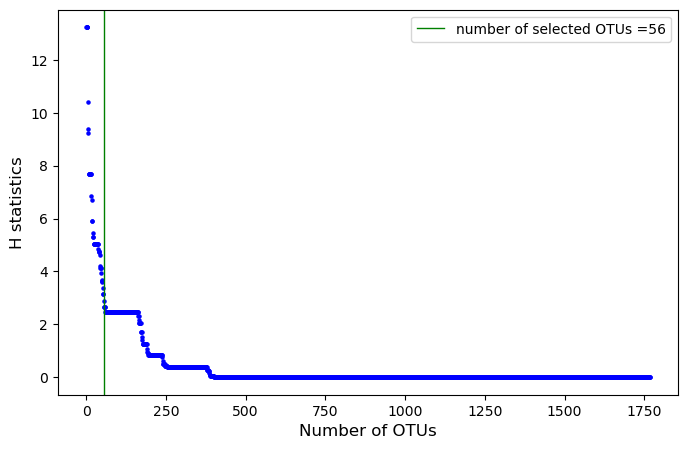

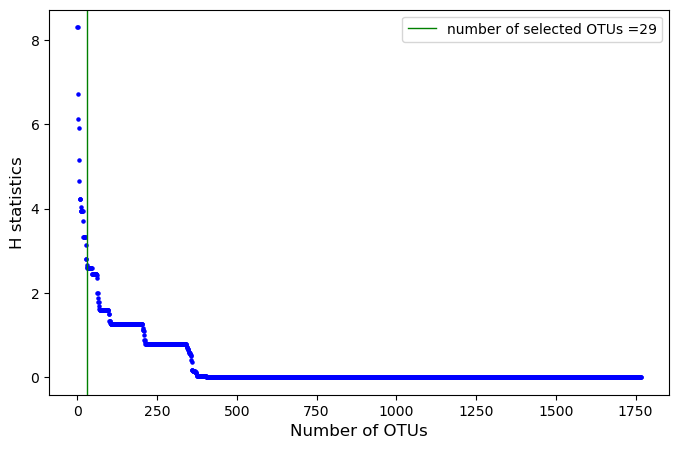

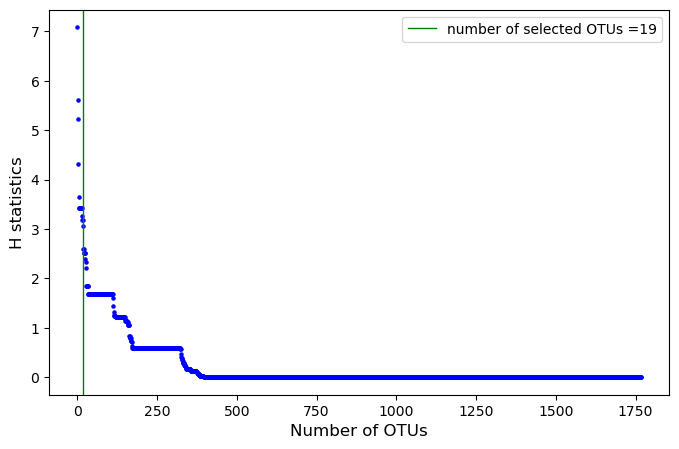

In [7]:
# select the OTUs
taxlabels = ['Burn','urban','duration']

selectedresult_list = []
for y in [burn_label,un_label,duration_label]:
    selectedresult=FS.SelectMicro_fun(df,y)
    selectedresult_list.append(selectedresult)
    
selectedresult.keys()

In [8]:
selectedOTU_index_Lasso_list = []
selectedOTU_index_FS_lasso_list = []

data_subset_list = []

for index, element in enumerate([burn_label,un_label,duration_label]):
    
    selectedresult = selectedresult_list[index]
    
    selectedOTU_index_FS = selectedresult['selected_indices']

    data = selectedresult['relative_abundance_data']
    data_df = pd.DataFrame(data,columns = ASVs)
    X_FS = selectedresult['selected_data']
    X_FS_df =pd.DataFrame(X_FS,columns = selectedresult['selected_columnames'])

    X_lasso_ft,selectedOTU_index_Lasso  = RunML.LassoFS_CV(data,element)
    X_lasso_ft_df = pd.DataFrame(X_lasso_ft,columns = ASVs[selectedOTU_index_Lasso])
    selectedOTU_index_Lasso_list.append(selectedOTU_index_Lasso)

    X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML.LassoFS_CV(X_FS,element)
    selectedOTU_index_FS_lasso = selectedOTU_index_FS[xlabel_FS_lasso_ft0]
    X_FS_lasso_ft_df = pd.DataFrame(X_FS_lasso_ft,columns = ASVs[selectedOTU_index_FS_lasso])
    selectedOTU_index_FS_lasso_list.append(selectedOTU_index_FS_lasso)
    
    data_subset = {"AllFeatures":data_df, 
               "SelectMicro": X_FS_df,
               "Lasso_finetune":X_lasso_ft_df,
                "FS_Lassofinetune":X_FS_lasso_ft_df
               #"Random":data
              }
    data_subset_list.append(data_subset)

Best alpha: 0.1
Best alpha: 0.05
Best alpha: 0.1
Best alpha: 0.05
Best alpha: 0.1
Best alpha: 0.05


In [9]:
for data in data_subset_list:
    print(f'The shape of the full selected dataset is ',np.shape(data['AllFeatures']))
    print(f'The shape of the FS selected dataset is ',np.shape(data['SelectMicro']))
    print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(data['Lasso_finetune']))
    print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(data['FS_Lassofinetune']))
    

The shape of the full selected dataset is  (59, 1768)
The shape of the FS selected dataset is  (59, 56)
The shape of the Lasso_finetune selected dataset is  (59, 14)
The shape of the FS_Lasso_finetune selected dataset is  (59, 15)
The shape of the full selected dataset is  (59, 1768)
The shape of the FS selected dataset is  (59, 29)
The shape of the Lasso_finetune selected dataset is  (59, 11)
The shape of the FS_Lasso_finetune selected dataset is  (59, 14)
The shape of the full selected dataset is  (59, 1768)
The shape of the FS selected dataset is  (59, 19)
The shape of the Lasso_finetune selected dataset is  (59, 7)
The shape of the FS_Lasso_finetune selected dataset is  (59, 12)


In [10]:
for index, element in enumerate([burn_label,un_label,duration_label]):
    targetLabel=element
    for i, (key, value) in enumerate(data_subset_list[index].items()):
        print(taxlabels[index])
        print(key)
        print(f"fisher_discriminant_ratio of {key} = {metric.fisher_discriminant_ratio(value,targetLabel)}")

Burn
AllFeatures
fisher_discriminant_ratio of AllFeatures = 0.036093571621673065
Burn
SelectMicro
fisher_discriminant_ratio of SelectMicro = 0.06774978734353485
Burn
Lasso_finetune
fisher_discriminant_ratio of Lasso_finetune = 0.15251671332794658
Burn
FS_Lassofinetune
fisher_discriminant_ratio of FS_Lassofinetune = 0.1520621629465562
urban
AllFeatures
fisher_discriminant_ratio of AllFeatures = 0.016829372994488615
urban
SelectMicro
fisher_discriminant_ratio of SelectMicro = 0.04191327732013825
urban
Lasso_finetune
fisher_discriminant_ratio of Lasso_finetune = 0.0642447586197016
urban
FS_Lassofinetune
fisher_discriminant_ratio of FS_Lassofinetune = 0.05315559790924114
duration
AllFeatures
fisher_discriminant_ratio of AllFeatures = 0.018576225758383434
duration
SelectMicro
fisher_discriminant_ratio of SelectMicro = 0.0478341257991233
duration
Lasso_finetune
fisher_discriminant_ratio of Lasso_finetune = 0.08887784057465911
duration
FS_Lassofinetune
fisher_discriminant_ratio of FS_Lassofin

### Model (default RF) 
NB and XG refer to qsh output in "../result"

In [11]:
#selected_index[0][1]

Burn
AllFeatures


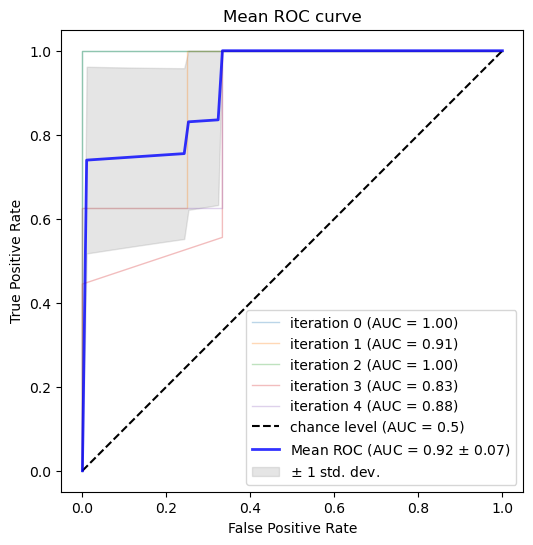

Accuracy: 0.780 (0.065), F1: 0.867 (0.036),MCC: nan (nan),AUC: 0.920 (0.067)


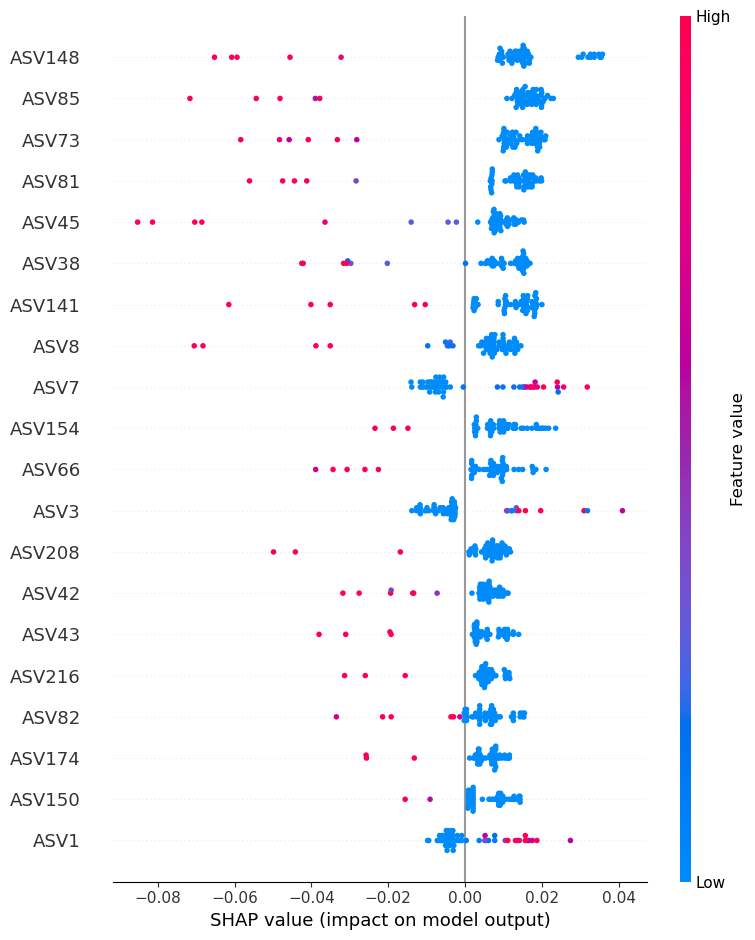

Burn
SelectMicro


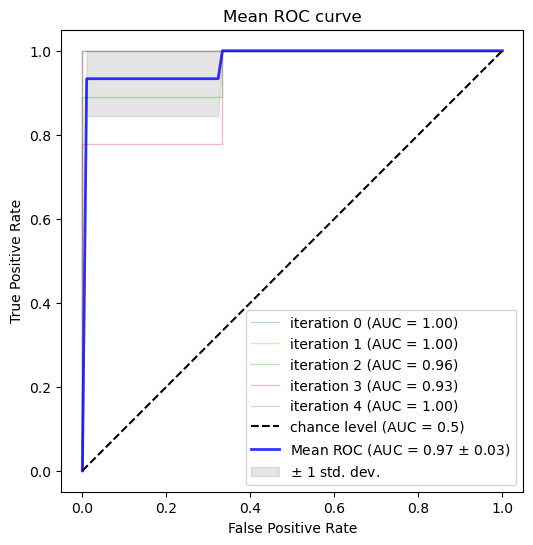

Accuracy: 0.897 (0.039), F1: 0.933 (0.022),MCC: 0.740 (0.113),AUC: 0.973 (0.030)


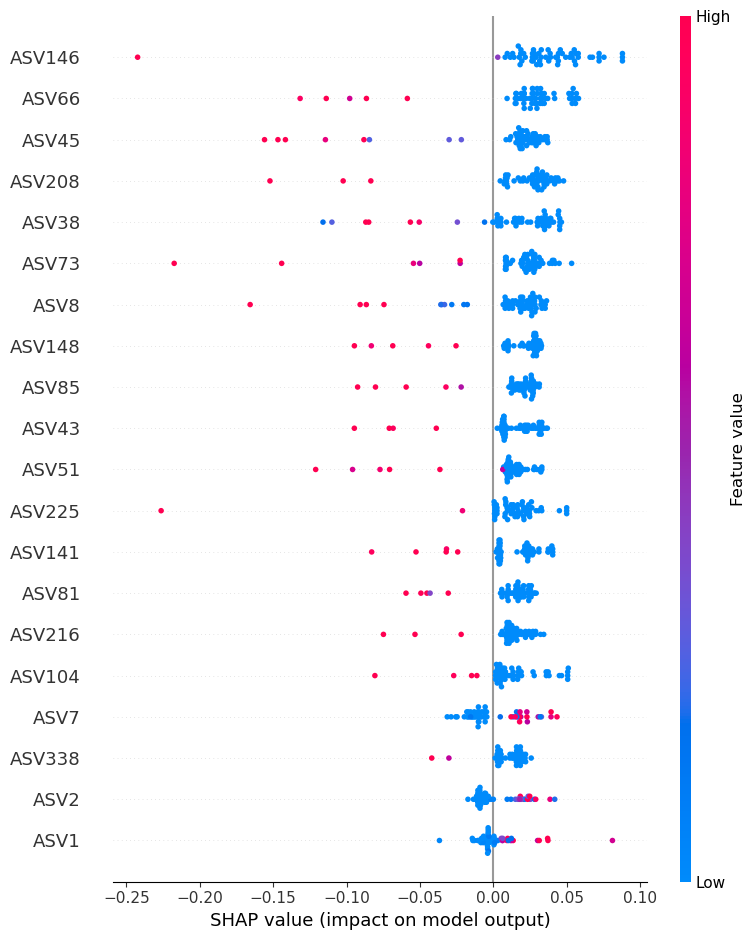

Burn
Lasso_finetune


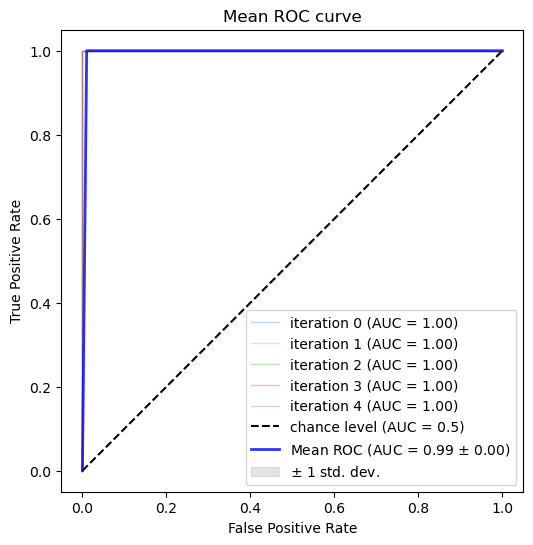

Accuracy: 0.914 (0.058), F1: 0.944 (0.035),MCC: 0.785 (0.155),AUC: 0.995 (0.000)


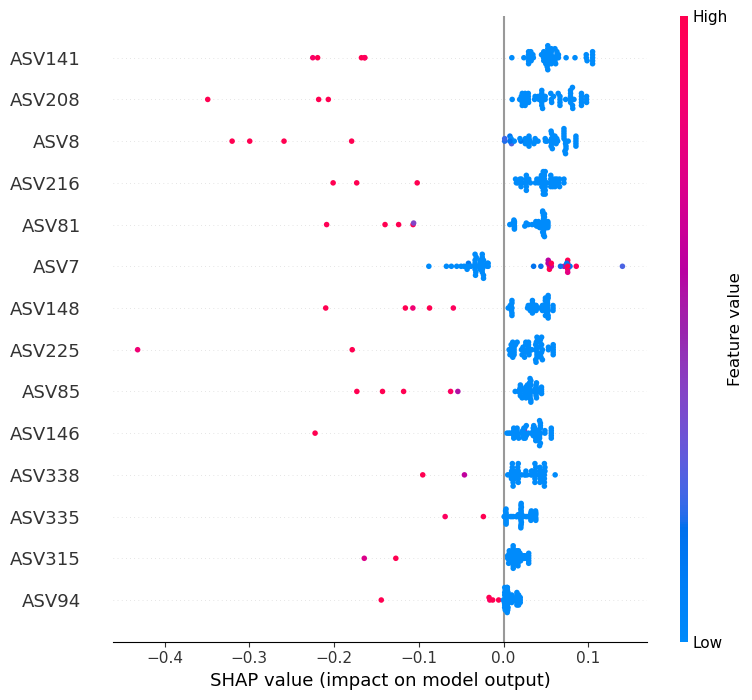

Burn
FS_Lassofinetune


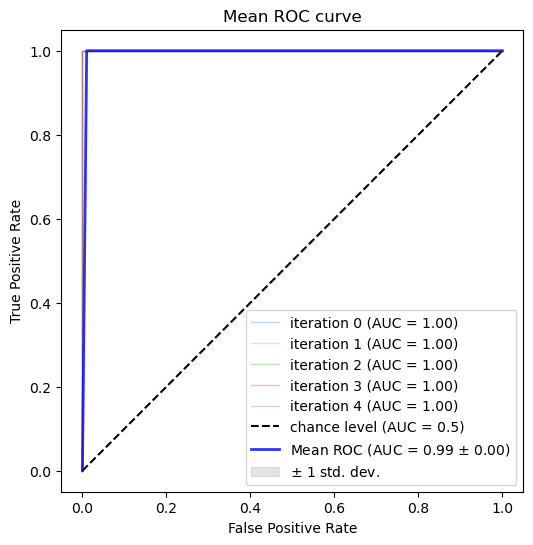

Accuracy: 0.930 (0.067), F1: 0.955 (0.042),MCC: 0.821 (0.178),AUC: 0.995 (0.000)


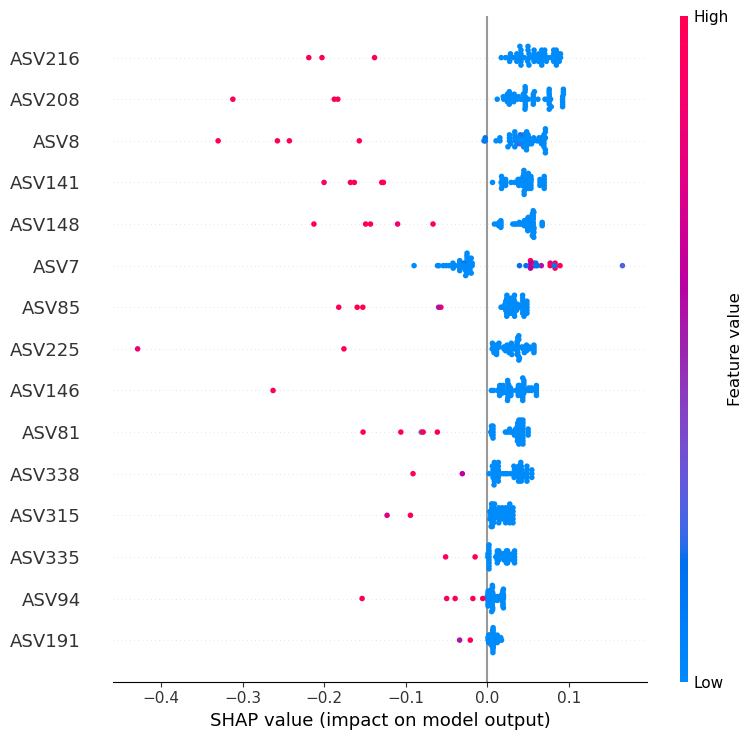

urban
AllFeatures


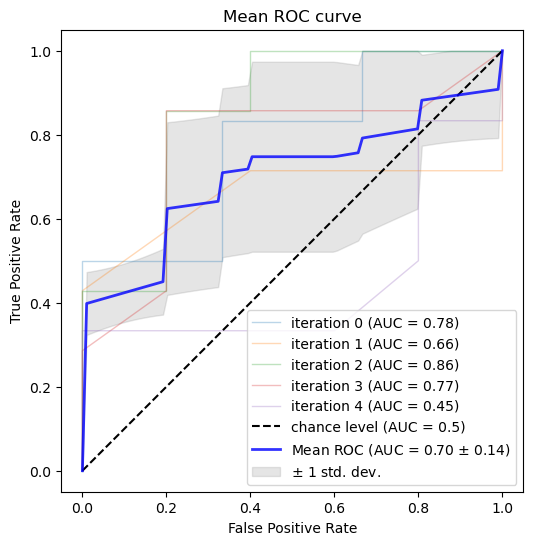

Accuracy: 0.556 (0.146), F1: 0.666 (0.128),MCC: 0.073 (0.374),AUC: 0.702 (0.142)


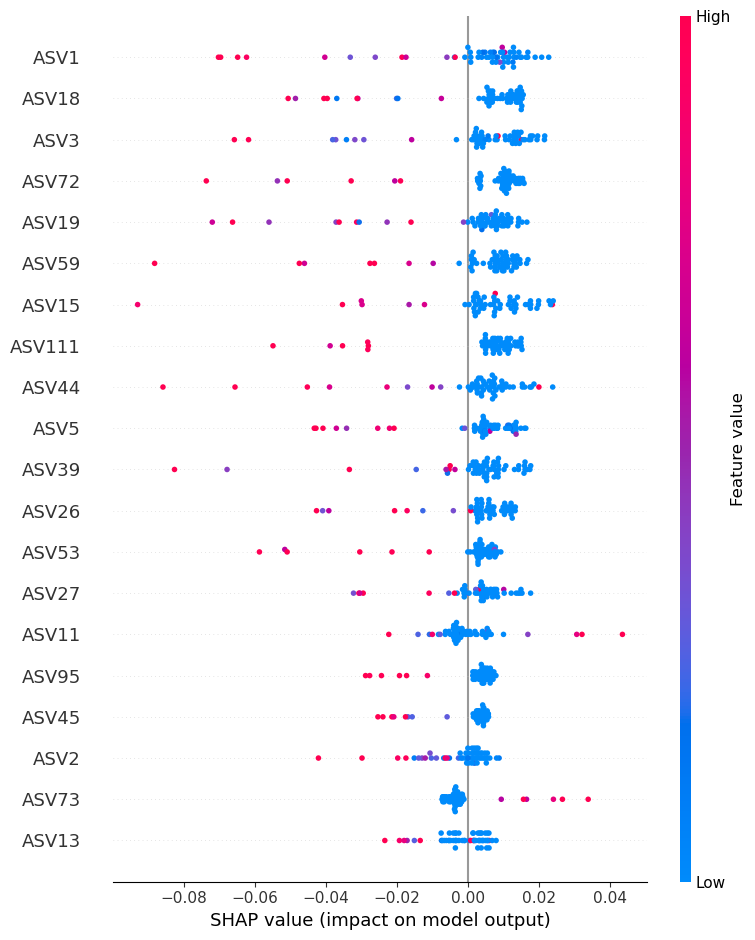

urban
SelectMicro


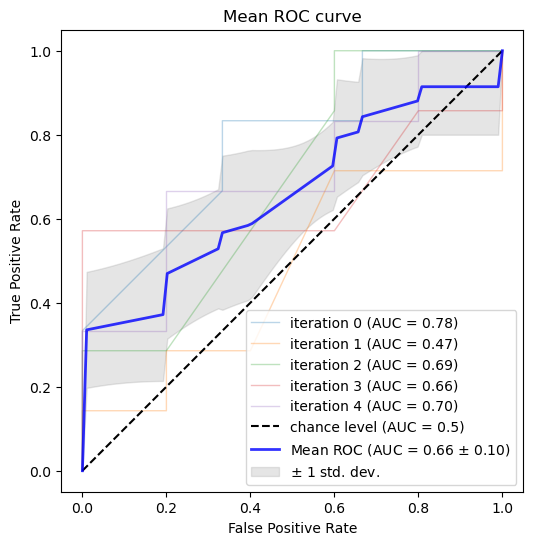

Accuracy: 0.627 (0.083), F1: 0.671 (0.095),MCC: 0.219 (0.271),AUC: 0.658 (0.102)


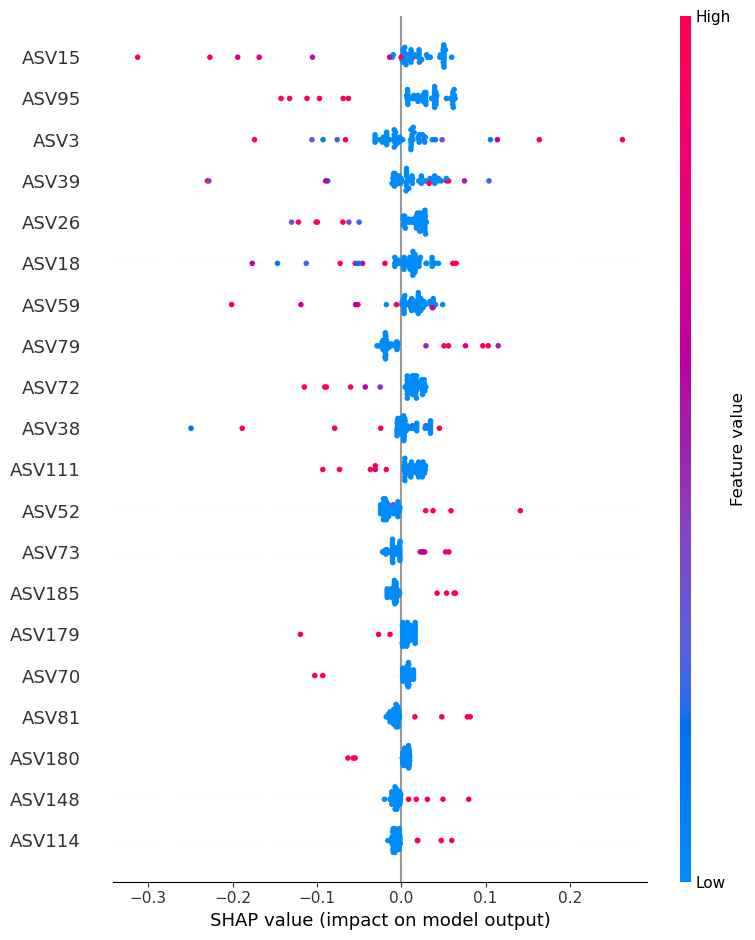

urban
Lasso_finetune


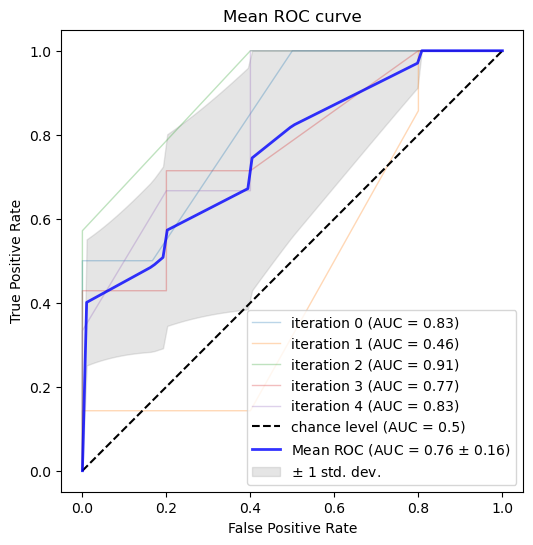

Accuracy: 0.712 (0.084), F1: 0.777 (0.059),MCC: 0.432 (0.209),AUC: 0.760 (0.159)


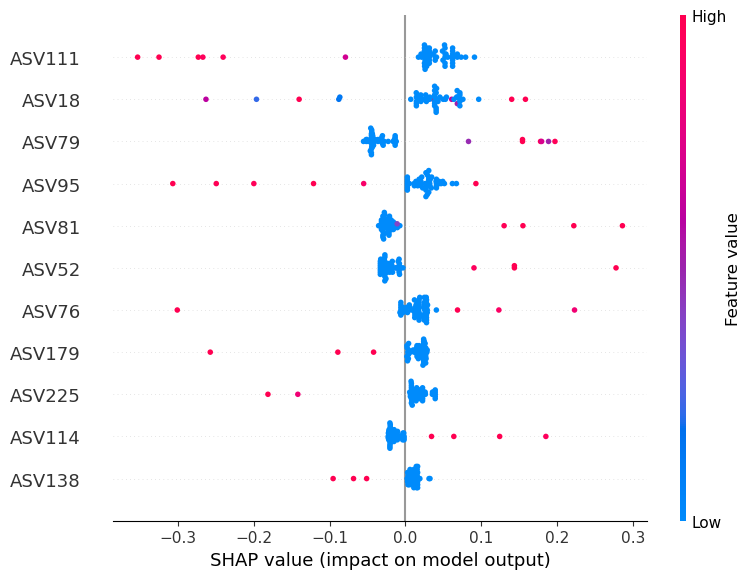

urban
FS_Lassofinetune


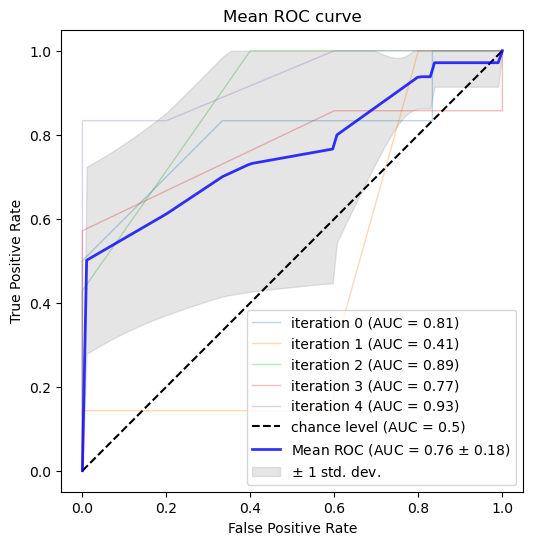

Accuracy: 0.748 (0.116), F1: 0.807 (0.074),MCC: 0.491 (0.263),AUC: 0.760 (0.183)


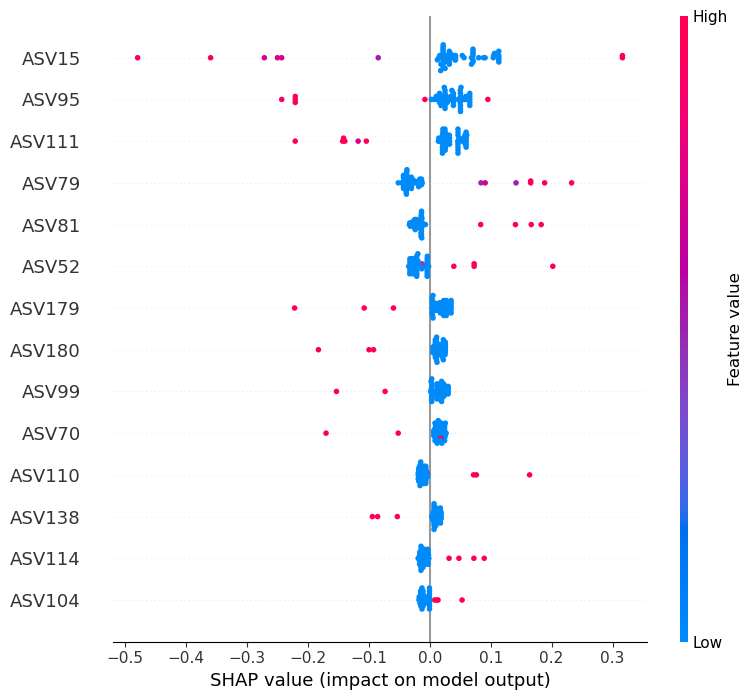

duration
AllFeatures


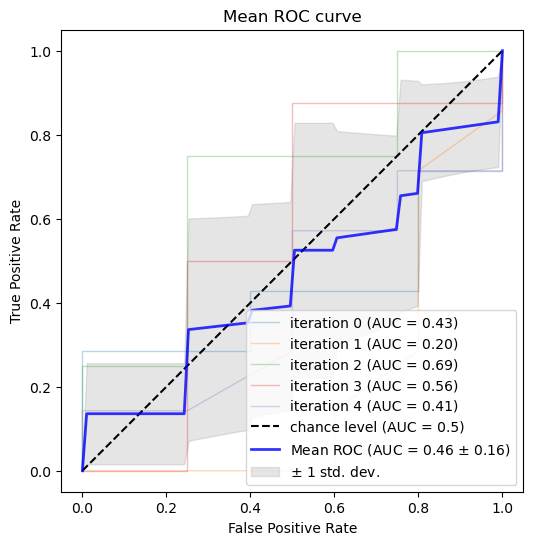

Accuracy: 0.591 (0.108), F1: 0.730 (0.077),MCC: nan (nan),AUC: 0.458 (0.163)


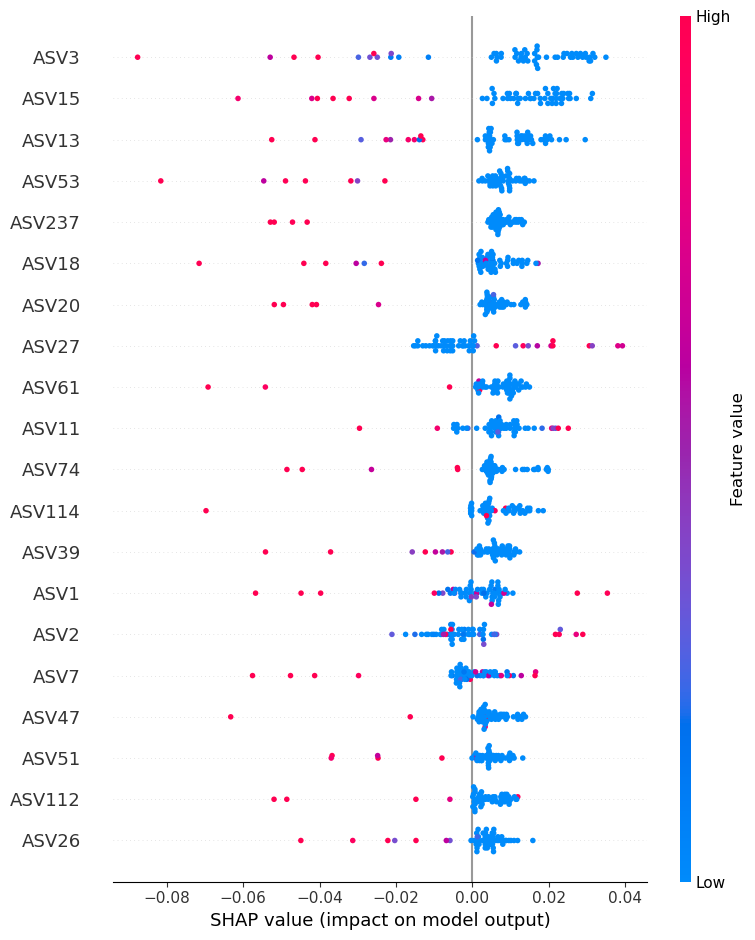

duration
SelectMicro


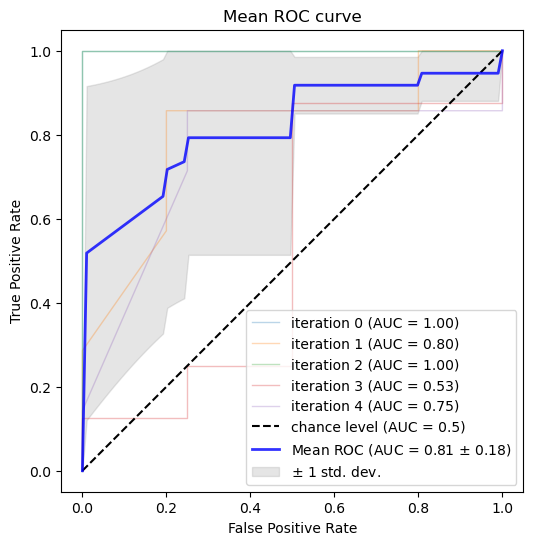

Accuracy: 0.761 (0.128), F1: 0.833 (0.077),MCC: 0.409 (0.389),AUC: 0.814 (0.175)


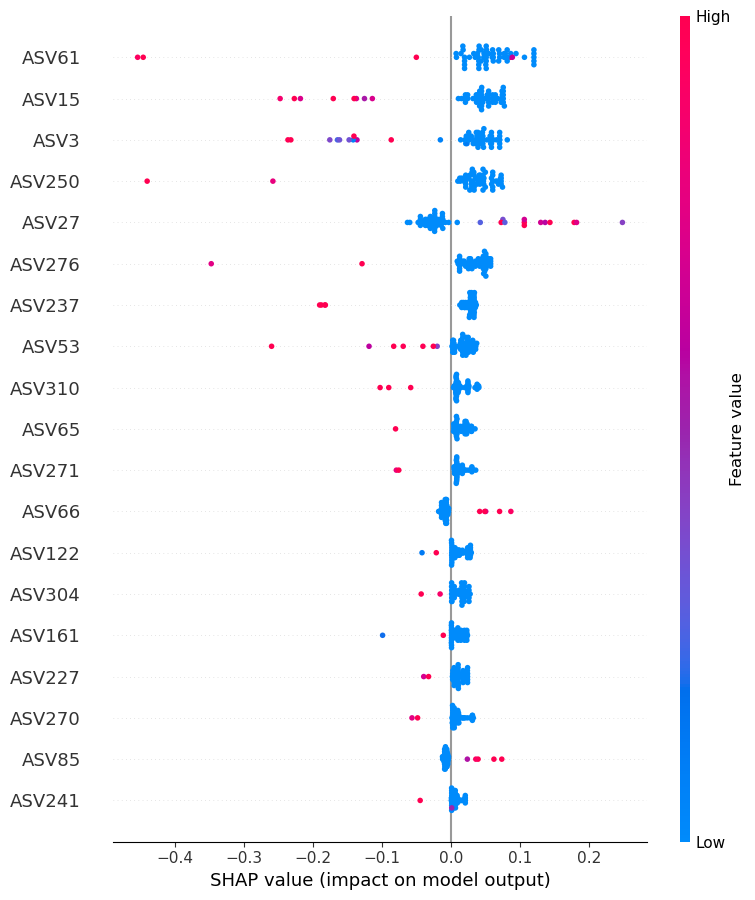

duration
Lasso_finetune


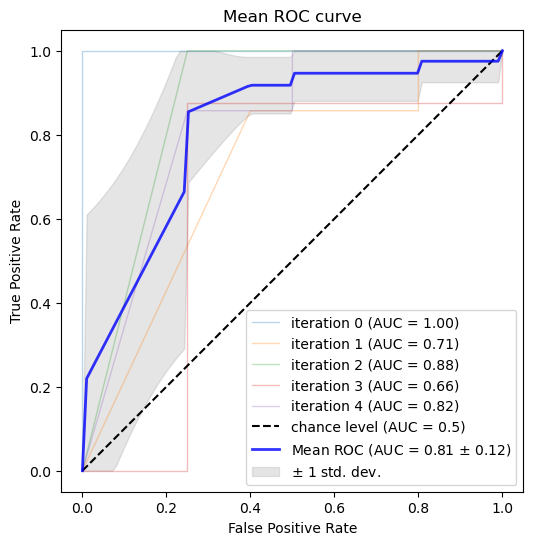

Accuracy: 0.780 (0.099), F1: 0.841 (0.068),MCC: 0.505 (0.246),AUC: 0.813 (0.121)


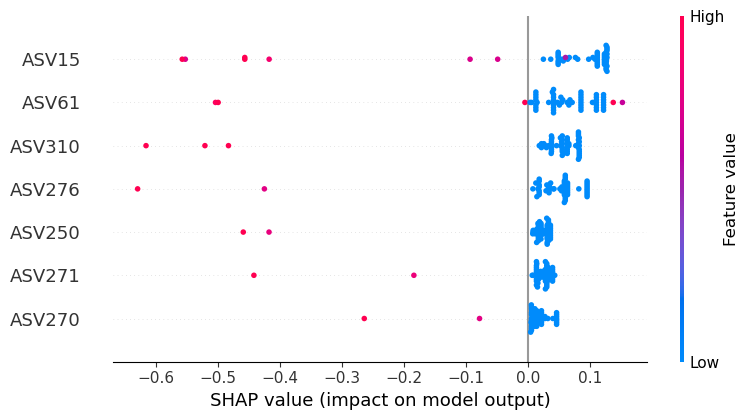

duration
FS_Lassofinetune


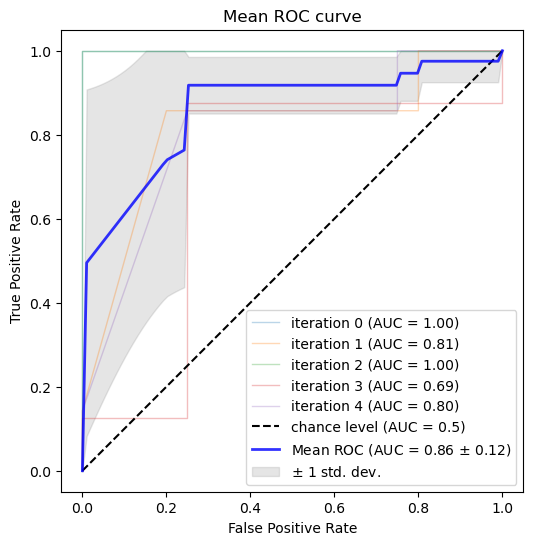

Accuracy: 0.780 (0.099), F1: 0.840 (0.069),MCC: 0.512 (0.247),AUC: 0.859 (0.122)


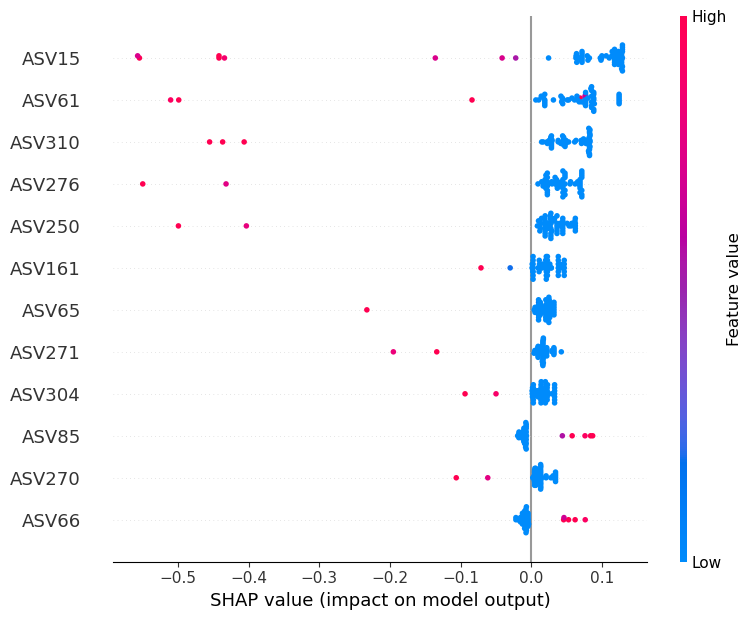

In [12]:
result_rf_list = []
for index, element in enumerate([burn_label,un_label,duration_label]):
    targetLabel=element
    for i, (key, value) in enumerate(data_subset_list[index].items()):
        print(taxlabels[index])
        print(key)
        result_rf_list.append(RunML.RF_model_SCV(value, y=element,plot=True, SMOTE=True,y_base = 1)
)


In [13]:
len(result_rf_list)# 3 labels *4 datasets

12

In [14]:
result_rf_fs = result_rf_list[1]

In [15]:
print(result_rf_fs['enrich'])

      Taxa enriched1 enriched2 enriched3 enriched4 enriched5
0     ASV1   Level 1   Level 1   Level 1   Level 1   Level 1
1   ASV104   Level 1   Level 1   Level 1     Other     Other
2    ASV11   Level 1   Level 1   Level 1   Level 1   Level 1
3    ASV13   Level 1   Level 1   Level 1   Level 1   Level 1
4   ASV133   Level 1   Level 1   Level 1   Level 1   Level 1
5   ASV139   Level 1     Other   Level 1     Other     Other
6   ASV141   Level 1     Other     Other     Other     Other
7   ASV146   Level 1     Other   Level 1   Level 1   Level 1
8   ASV148     Other     Other   Level 1     Other     Other
9    ASV15   Level 1   Level 1   Level 1   Level 1   Level 1
10  ASV150   Level 1   Level 1     Other   Level 1   Level 1
11  ASV154   Level 1   Level 1     Other     Other   Level 1
12  ASV159   Level 1   Level 1   Level 1     Other   Level 1
13  ASV174   Level 1     Other   Level 1     Other     Other
14   ASV18   Level 1   Level 1   Level 1   Level 1   Level 1
15  ASV181   Level 1    

In [16]:
# check with annual
result_rf_fs3 = result_rf_list[9]

In [17]:
print(result_rf_fs3['enrich'])

      Taxa enriched1 enriched2 enriched3 enriched4 enriched5
0   ASV122     Other   Level 1     Other   Level 1   Level 1
1    ASV15     Other     Other   Level 1     Other     Other
2   ASV161     Other   Level 1     Other   Level 1   Level 1
3   ASV227   Level 1     Other     Other   Level 1   Level 1
4   ASV237     Other     Other     Other   Level 1     Other
5   ASV241   Level 1   Level 1     Other   Level 1   Level 1
6   ASV250   Level 1     Other   Level 1   Level 1     Other
7    ASV27   Level 1   Level 1   Level 1   Level 1   Level 1
8   ASV270   Level 1   Level 1     Other     Other   Level 1
9   ASV271     Other   Level 1     Other   Level 1   Level 1
10  ASV276   Level 1   Level 1   Level 1     Other     Other
11    ASV3     Other     Other   Level 1     Other     Other
12  ASV304     Other     Other   Level 1   Level 1   Level 1
13  ASV310     Other   Level 1     Other   Level 1     Other
14   ASV53     Other     Other     Other     Other     Other
15   ASV61   Level 1    

In [18]:
result_rf_fs.keys()

dict_keys(['y_information', 'x_true', 'SHAP', 'enrich'])

Text(0.5, 1.0, 'FS-Lasso SHAP Summary')

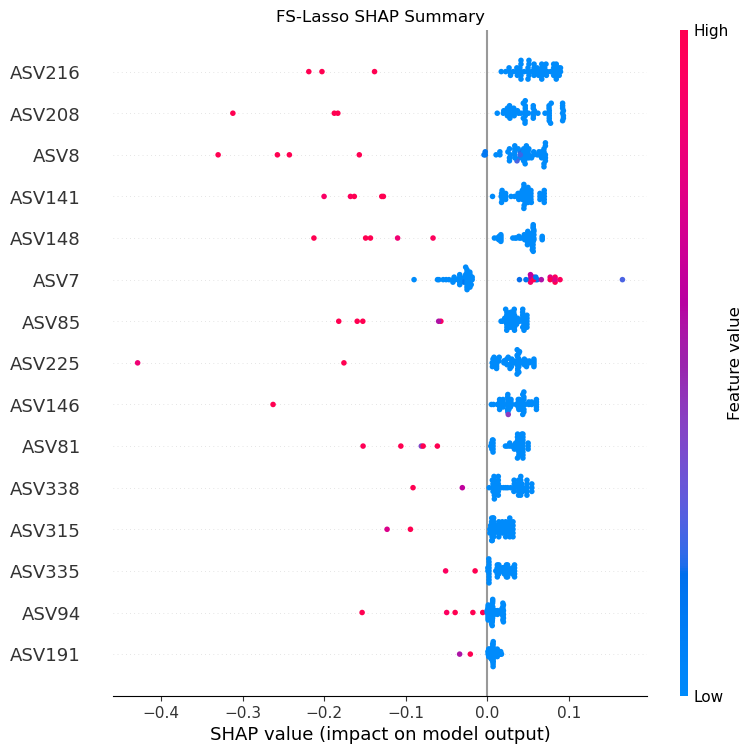

In [19]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

shap.summary_plot(result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'],show=False)
plt.title("FS-Lasso SHAP Summary")



Text(0.5, 1.0, 'Lasso SHAP Summary')

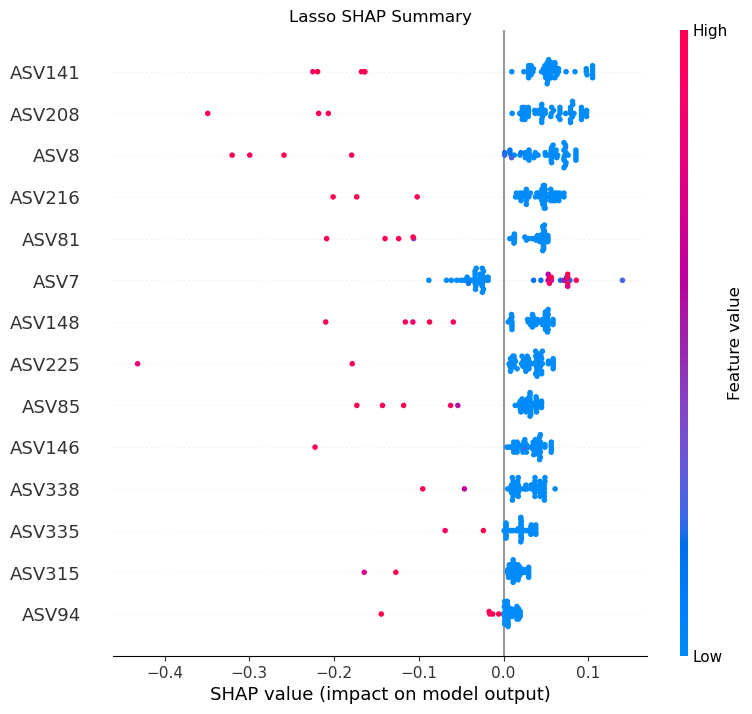

In [20]:

# Second SHAP summary plot

shap.summary_plot(result_rf_list[2]['SHAP'][:,:,1],result_rf_list[2]['x_true'],show=False)
plt.title("Lasso SHAP Summary")

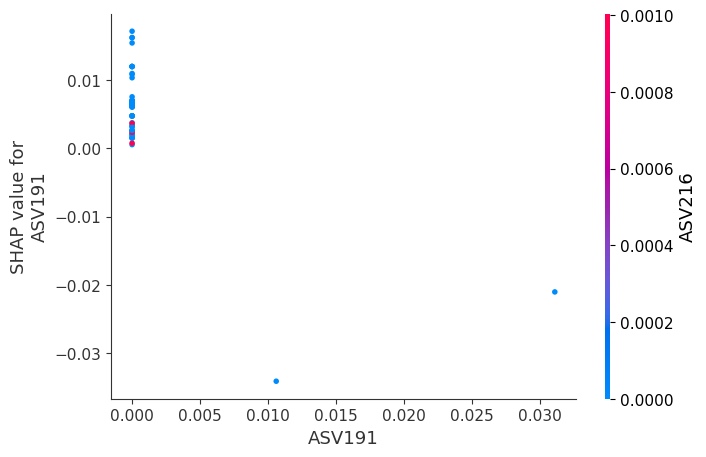

In [21]:
# analyzing ASV 191


# make interaction plot.
# when there is no 191, if the value of 216 is low then there is more likelt the soil is burned
# when there is 191 and 216 is none, there is more likely the soil is not burn, and t
shap.dependence_plot('ASV191', result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'], interaction_index="ASV216")


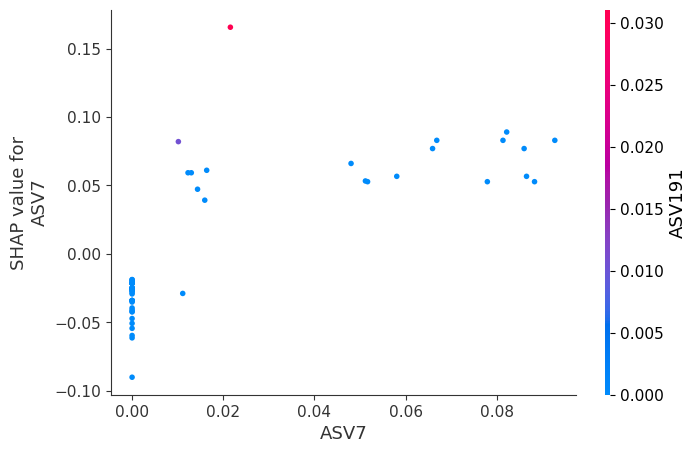

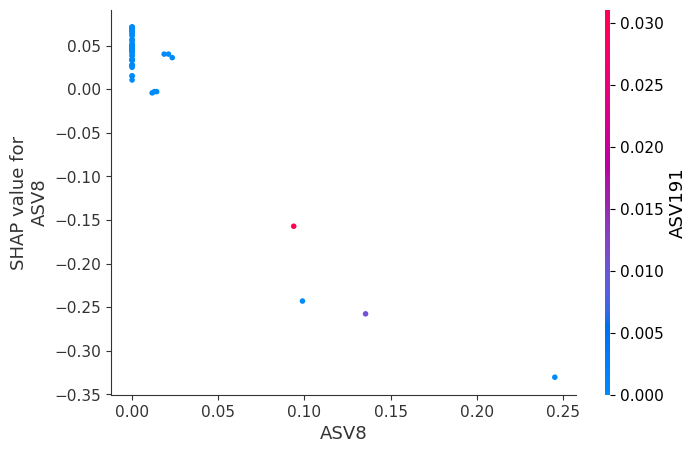

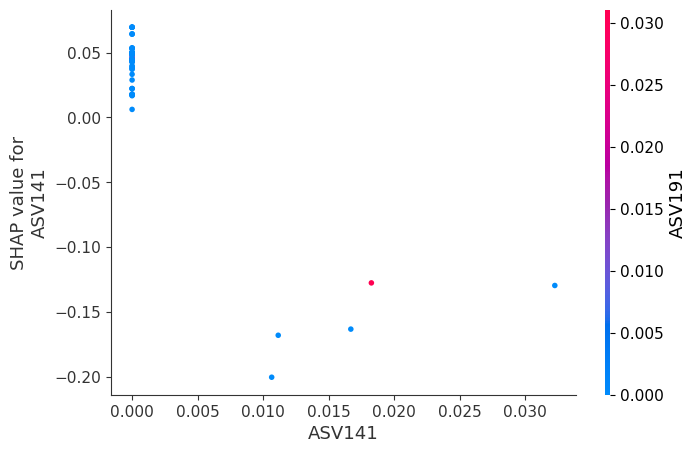

In [22]:
# make interaction plot.
# if there is 
shap.dependence_plot('ASV7', result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'], interaction_index="ASV191")
shap.dependence_plot('ASV8', result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'], interaction_index="ASV191")
shap.dependence_plot('ASV141', result_rf_list[3]['SHAP'][:,:,1], result_rf_list[3]['x_true'], interaction_index="ASV191")

In [23]:
FS_lasso_df = result_rf_list[3]['x_true']

# Get the indices where array1 is not zero
indices = np.where(FS_lasso_df['ASV191'] != 0)

ASV191_df = FS_lasso_df.loc[indices]
SHAP_ASV191 = result_rf_list[3]['SHAP'][:,:,1][indices]

In [24]:
shap.initjs()# base line is induced
shap.force_plot(0.49, SHAP_ASV191[1,:], ASV191_df.iloc[1])

In [25]:
indices

(array([ 2, 21]),)

In [26]:
shap.force_plot(0.49, SHAP_ASV191[0,:], ASV191_df.iloc[0])